# **Sistema de Recomendación Política con KNN**

**Proyecto Académico Final - Ingeniería de Sistemas**

---

#### 📋 Información del Proyecto

- **Autores**:

  - Duvan Santiago Matallana Jiménez,
  - Laura EStefanía Latorre Pachón,
- **Fecha**: Noviembre 2025
- **Repositorio**: [knn-political-recommendation]()

- **Institución**: Universidad de Cundinamarca

---

#### 📝 Descripción

Este proyecto implementa un sistema completo de Machine Learning que recomienda
candidatos presidenciales ficticios basándose en las respuestas de un test de
33 características políticas, utilizando el algoritmo K-Nearest Neighbors (KNN)
optimizado.

---

#### 🎯 Objetivos

1. Desarrollar un modelo KNN optimizado para clasificación multiclase (10 candidatos)
2. Implementar técnicas de selección de features para mejorar el rendimiento
3. Optimizar hiperparámetros (K y métrica de distancia) mediante análisis exhaustivo
4. Exportar modelo entrenado para integración con sistema web (FastAPI + React)

---

#### 🛠️ Tecnologías

scikit-learn | pandas | numpy | matplotlib | seaborn


### **Configuración, Librerías e Importaciones**

Esta celda inicializa el entorno del proyecto. Se importan todas las librerías necesarias para la manipulación de datos (Pandas), operaciones numéricas (NumPy), visualización (Matplotlib, Seaborn) y los módulos específicos de `sklearn` permitidos para el preprocesamiento (MinMaxScaler, KNNImputer) y la selección de features (SelectKBest, RFE).

También se configuran los estilos visuales para las gráficas y se define la variable global `FILE_PATH` que apunta al dataset. Se omite deliberadamente la fijación de un `random_state`.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import os
import joblib
import warnings
from tqdm.notebook import tqdm # For progress bars
from collections import defaultdict
from typing import Tuple, Dict, List, Optional, Any

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

FILE_PATH = "/content/voter_intentions_3000.csv"

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5

###**Clase Data_Loader** - `Data_Loader`

Esta sección inicializa la primera fase del proyecto: la carga y limpieza inicial del dataset. La clase `Data_Loader` es responsable de garantizar que los datos estén en el formato correcto para el análisis exploratorio subsiguiente.

**Responsabilidades Clave:**
1.  **Carga:** Leer el archivo `voter_intentions_3000(in).csv`.
2.  **Creación del Target:** Generar la variable `target_id` (la intención de voto/candidato a recomendar) siguiendo la lógica de priorización.
3.  **Encoding Manual:** Mapear los nombres de candidatos a IDs numéricos, **comenzando desde 1** para cumplir con la restricción académica.
4.  **Limpieza:** Eliminar las filas donde no se pudo asignar ningún candidato y las columnas de *strings* de votación ya procesadas.
5. Separación: Dividir en features (X) y target (y).

**Salidas Esperadas:**
* `X`: DataFrame con 30 features numéricas.
* `y`: Series con target codificado (enteros 1-10).
* `TARGET_MAP`: Diccionario inverso {1: 'Candidato_A', ...}.

In [5]:
class Data_Loader:
    """
    Loads the raw dataset, defines the 24 valid features (X) and
    the target variable (y) based on the feature analysis performed
    on the dataset.
    """

    def __init__(self, file_path: str,
                 numerical_features: List[str],
                 ordinal_features: List[str]):
        """
        Initializes the loader with the dataset path and feature lists.
        Args:
            file_path (str): Path to the .csv dataset file.
            numerical_features (List[str]): List of column names to be
                                            treated as numerical.
            ordinal_features (List[str]): List of column names to be
                                          treated as ordinal.
        """
        self.file_path = file_path
        self.numerical_features = numerical_features
        self.ordinal_features = ordinal_features
        self.all_features = self.numerical_features + self.ordinal_features
        self.target_map: Dict[int, str] = {}
        print(f"data_loader initialized for file: {self.file_path}")

    def load_dataset(self) -> Tuple[pd.DataFrame, pd.Series, Dict[int, str]]:
        """
        Loads data, defines X (24 features) and y (target).
        - Drops rows where 'intended_vote' (target) is missing.
        - Selects only the 24 specified features for X.
        - Generates and saves a mapping for the target variable 'y'.

        Returns:
            Tuple[pd.DataFrame, pd.Series, Dict[int, str]]:
                - X_raw: DataFrame of raw features (24 columns).
                - y_raw: Series of raw target labels (encoded).
                - target_map: Mapping dictionary {0: 'Undecided', 1: 'Cand_A', ...}
        """
        try:
            data = pd.read_csv(self.file_path)
            print(f"Dataset loaded successfully. Original shape: {data.shape}")
        except FileNotFoundError:
            print(f"Error: File not found at '{self.file_path}'.")
            return pd.DataFrame(), pd.Series(dtype=int), {}
        except Exception as e:
            print(f"An error occurred during file loading: {e}")
            return pd.DataFrame(), pd.Series(dtype=int), {}

        # Drop rows where the target ('intended_vote') is missing
        initial_rows = len(data)
        data = data.dropna(subset=['intended_vote'])
        if initial_rows > len(data):
            print(f"Dropped {initial_rows - len(data)} rows with missing 'intended_vote' (target).")

        y_series = data['intended_vote']
        unique_classes = sorted(y_series.unique())
        reverse_map: Dict[str, int] = {}

        if "Undecided" in unique_classes:
            reverse_map["Undecided"] = 0
            self.target_map[0] = "Undecided"
            unique_classes.remove("Undecided")

        candidate_id = 1

        for candidate in unique_classes:
            reverse_map[candidate] = candidate_id
            self.target_map[candidate_id] = candidate
            candidate_id += 1

        y_raw = y_series.map(reverse_map).astype(int)
        print(f"Target 'y' ('intended_vote') defined. {len(self.target_map)} classes.")

        try:
            with open('target_map.json', 'w') as f:
                json.dump(self.target_map, f, indent=4)
            print("target_map.json guardado.")
        except Exception as e:
            print(f"Error guardando target_map.json: {e}")

        try:
            X_raw = data.loc[y_raw.index, self.all_features].copy()
            print(f"Features 'X' defined with {X_raw.shape[1]} columns (based on frontend spec).")
        except KeyError as e:
            print(f"Error selecting features: Column not found. {e}")
            return pd.DataFrame(), pd.Series(dtype=int), {}
        except Exception as e:
            print(f"An error occurred during feature selection: {e}")
            return pd.DataFrame(), pd.Series(dtype=int), {}

        print(f"Data loading complete. X shape: {X_raw.shape}, y shape: {y_raw.shape}")
        return X_raw, y_raw, self.target_map

### **Preprocesamiento de datos** - `Data_Preprocessor`

Esta sección es responsable de preparar los datos para el modelo. Como se observó en el EDA, las features tienen escalas muy diferentes (algunas de 0-10, otras de 0-100). KNN basa sus predicciones en la "distancia" entre puntos, por lo que una feature con una escala de 0-100 dominaría sobre una de 0-10.

**Responsabilidades:**

1. **Imputación de Nulos:** Rellenar los valores faltantes identificados en el EDA. Se utilizará `KNNImputer` de `sklearn`, que es una técnica robusta que utiliza los propios vecinos para estimar el valor faltante.

2. **Normalización:** Escalar todas las 30 features al mismo rango (0 a 1) usando `MinMaxScaler`. Esto asegura que todas las features contribuyan por igual al cálculo de la distancia.

3. **División de Datos:** Separar los datos en conjuntos de entrenamiento y prueba (`train_test_split`).

4. **Exportación de Procesadores:** Guardar los objetos `imputer` y `scaler` (entrenados solo con datos de `train`) para su uso futuro en producción.

In [6]:
class Data_Preprocessor:
    """
    Handles data imputation and scaling according to defined
    strategies for numerical and ordinal features.
    This class uses scikit-learn's ColumnTransformer to create a
    reproducible preprocessing pipeline.
    """

    def __init__(self, numerical_features: List[str], ordinal_features: List[str]):
        """
        Initializes the preprocessor with distinct pipelines for
        numerical and ordinal features.
        Args:
            numerical_features (List[str]): Columns to be treated as
                continuous numerical data.
            ordinal_features (List[str]): Columns to be treated as
                discrete ordinal data.
        """
        self.numerical_features = numerical_features
        self.ordinal_features = ordinal_features

        # Imputations using median and scaling with StandardScaler
        numerical_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        ordinal_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1))
        ])
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_pipeline, self.numerical_features),
                ('ord', ordinal_pipeline, self.ordinal_features)
            ],
            remainder='passthrough'
        )

        self.fitted_columns: List[str] = []
        print("Data_Preprocessor initialized.")
        print(f"  -> Numerical features: {len(self.numerical_features)}")
        print(f"  -> Ordinal features: {len(self.ordinal_features)}")


    def fit_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Fits the preprocessing pipeline to the data and transforms it.
        (Typically used on X_train).
        Args:
            X (pd.DataFrame): The raw training features DataFrame.
        Returns:
            pd.DataFrame: The processed (imputed and scaled) data.
        """
        print("Fitting and transforming data...")

        X_processed = self.preprocessor.fit_transform(X)
        self.fitted_columns = list(self._get_feature_names_out(X))

        print(f"Data processed. Output shape: {X_processed.shape}")
        return pd.DataFrame(X_processed, columns=self.fitted_columns, index=X.index)


    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms new data using the already-fitted pipeline.
        (Typically used on X_test or new prediction data).
        Args:
            X (pd.DataFrame): The raw new features DataFrame.

        Returns:
            pd.DataFrame: The processed (imputed and scaled) data.
        """
        if not self.fitted_columns:
            raise RuntimeError("Preprocessor has not been fitted. Call 'fit_transform' first.")

        print("Transforming data using fitted preprocessor...")
        X_processed = self.preprocessor.transform(X)
        print(f"Data processed. Output shape: {X_processed.shape}")
        return pd.DataFrame(X_processed, columns=self.fitted_columns, index=X.index)


    def _get_feature_names_out(self, X: pd.DataFrame) -> List[str]:
        """
        Helper function to get correctly ordered feature names after
        ColumnTransformer processing.
        """
        if hasattr(self.preprocessor, 'get_feature_names_out'):
            return self.preprocessor.get_feature_names_out()
        else:
            print("Warning: Using manual feature name fallback.")
            new_names = []

            for name, trans, cols in self.preprocessor.transformers_:
                if trans == 'passthrough':
                    processed_cols = set(self.numerical_features + self.ordinal_features)
                    passthrough_cols = [col for col in X.columns if col not in processed_cols]
                    new_names.extend(passthrough_cols)
                elif name == 'num':
                    new_names.extend(self.numerical_features)
                elif name == 'ord':
                    new_names.extend(self.ordinal_features)
            return new_names

    def save_processor(self, filepath: str = "data_preprocessor.joblib"):
        """
        Saves the fitted ColumnTransformer object to disk.
        Args:
            filepath (str): The path to save the .joblib file.
        """
        try:
            joblib.dump(self.preprocessor, filepath)
            print(f"Data preprocessor saved successfully to {filepath}")
        except Exception as e:
            print(f"Error saving preprocessor: {e}")

### **Selección de Features** - `Feature_Extractor`

Esta sección aborda la reducción de dimensionalidad. El objetivo no es tomar una decisión final, sino generar dos conjuntos de features "candidatos" (K=20 y K=25) para su posterior evaluación.

Se utilizarán dos técnicas que cumplen con las restricciones del proyecto:

**Random Forest Importance:** Un método multivariante que evalúa la importancia de una feature en el contexto de otras.

**Correlación de Pearson:** Un método univariante que mide la relación lineal de cada feature con el target.

Se utilizará el ranking de Random Forest como el método principal para crear los conjuntos K=20 y K=25, ya que es un método más robusto (multivariante). El método de Pearson se usará como un análisis comparativo y de justificación.

**Responsabilidades:**

1. **Random Forest (RF)**: Entrenar un RF y extraer un ranking de importancia de las 30 features.

2. **Pearson**: Calcular la correlación absoluta de las 30 features con el target.

3. **Comparación**: Visualizar ambos rankings y comparar la superposición entre ellos.

4. **Exportación**: Guardar las dos listas de features (`features_k20.json` y `features_k25.json`).

5. **Transformación**: Crear cuatro nuevos DataFrames: `X_train_k20`, `X_test_k20`, `X_train_k25`, y `X_test_k25`.

In [8]:
class Feature_Extractor:
    """
    Handles supervised feature extraction using Linear Discriminant Analysis (LDA).

    This class is responsible for fitting the LDA transformer on the
    preprocessed training data and transforming both training and test
    sets into a lower-dimensional feature space optimized for classification.
    """

    def __init__(self, n_lda_components: int = 10):
        """
        Initializes the LDA transformer.

        Args:
            n_lda_components (int): Number of components for LDA.
                                    (Max is n_classes - 1).
        """
        if n_lda_components > 10:
            print(f"Warning: Truncating LDA components to 10 (n_classes - 1).")
            n_lda_components = 10

        self.n_lda_components = n_lda_components
        self.lda_transformer = LDA(n_components=self.n_lda_components)
        self.is_fitted = False
        print("feature_selector initialized.")
        print(f"  -> LDA components: {self.n_lda_components}")


    def _to_dataframe(self, data: np.ndarray, prefix: str = 'LDA') -> pd.DataFrame:
        """
        Helper to convert numpy array output to a labeled DataFrame.
        Args:
            data (np.ndarray): The data transformed by LDA.
            prefix (str): The prefix for column names (e.g., 'LDA_1').
        Returns:
            pd.DataFrame: A DataFrame with labeled columns.
        """
        n_components = data.shape[1]
        cols = [f"{prefix}_{i+1}" for i in range(n_components)]
        return pd.DataFrame(data, columns=cols)


    def fit_transform(self, X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
        """
        Fits the LDA transformer to the training data and transforms it.
        (Typically used on X_train).
        Args:
            X (pd.DataFrame): The preprocessed (scaled) training features.
            y (pd.Series): The training target labels (required for LDA).
        Returns:
            pd.DataFrame: The transformed (LDA) training features.
        """
        print("Fitting and transforming data with LDA...")
        if X.isnull().values.any():
            raise ValueError("X contains NaNs. feature_selector requires fully imputed data.")
        if y.isnull().values.any():
            raise ValueError("y contains NaNs. LDA cannot be fitted.")

        X_lda = self.lda_transformer.fit_transform(X, y)
        self.is_fitted = True
        print(f"LDA transformation complete. Output shape: {X_lda.shape}")
        return self._to_dataframe(X_lda)


    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Applies the already-fitted LDA transformer to new data.
        (Typically used on X_test or new prediction data).
        Args:
            X (pd.DataFrame): The preprocessed (scaled) new features.
        Returns:
            pd.DataFrame: The transformed (LDA) new features.
        """
        if not self.is_fitted:
            raise RuntimeError("Transformer has not been fitted. Call 'fit_transform' first.")

        print("Transforming new data using fitted LDA transformer...")
        X_lda = self.lda_transformer.transform(X)
        print(f"LDA transformation complete. Output shape: {X_lda.shape}")
        return self._to_dataframe(X_lda)


    def save_transformer(self, filepath: str = "feature_selector.joblib"):
        """
        Saves the fitted LDA transformer object to disk.
        Args:
            filepath (str): The path to save the .joblib file.
        """
        if not self.is_fitted:
            print("Warning: No transformer to save (not fitted).")
            return
        try:
            joblib.dump(self.lda_transformer, filepath)
            print(f"Feature selector (LDA) saved successfully to {filepath}")
        except Exception as e:
            print(f"Error saving transformer: {e}")

### **Clasificador manual KNN** - `Manual_KNN_Classifier`

Esta es la clase principal del modelo. Esta clase implementa el algoritmo K-Nearest Neighbors manualmente.

**Responsabilidades:**

1. `fit(X, y)`: Ser un clasificador "perezoso" (lazy learner). Simplemente almacena el conjunto de datos de entrenamiento en memoria.

2. `_calculate_distances_vectorized(point, metric)`: Calcular la distancia (Euclidiana o Manhattan) desde un único punto de prueba a todos los puntos de entrenamiento de forma eficiente.

3. `_weighted_vote(labels, distances)`: Realizar la predicción de la clase. En lugar de un voto uniforme (donde cada vecino vale 1), se implementa un voto ponderado por distancia inversa. Los vecinos más cercanos tienen más influencia. También maneja el caso de distancia cero (una coincidencia exacta).

4. `predict(X_test, k, metric)`: Iterar sobre cada punto en el conjunto de prueba, encontrar sus K vecinos más cercanos y usar _weighted_vote para determinar la clase predicha.

5. `predict_proba(X_test, k, metric)`: Similar a predict, pero también devuelve la "confianza" de la predicción, calculada como el peso total del voto de la clase ganadora dividido por el peso total de todos los K vecinos.

In [11]:
class Manual_KNN_Classifier:
    """
    Implements the K-Nearest Neighbors (KNN) algorithm from scratch
    using Cosine Similarity.
    This classifier does not use any sklearn functions for its
    core logic (similarity, voting, prediction) and is optimized
    to use only the 'cosine' metric.
    """

    def __init__(self):
        """Initializes the classifier. Data is stored on 'fit'."""
        self.X_train = None
        self.y_train = None
        print("manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.")


    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """
        "Fits" the data. For KNN, this just means storing the training set.
        Args:
            X_train (pd.DataFrame): Training features.
            y_train (pd.Series): Training target labels.
        """
        # Store as numpy arrays for efficient computation
        self.X_train = X_train.values
        self.y_train = y_train.values
        print(f"Data fitted. Stored {self.X_train.shape[0]} training samples.")


    def _calculate_similarities_vectorized(self, x_test_point: np.ndarray) -> np.ndarray:
        """
        Calculates the Cosine Similarity from one test point
        to all training points. Implemented 100% manually using numpy.
        Args:
            x_test_point (np.ndarray): A single sample from the test set.
        Returns:
            np.ndarray: An array of similarities (shape: [n_train_samples]).
        """
        # Cosine Similarity = (A · B) / (||A|| * ||B||)

        # (A · B) -> Dot product of test point with all train rows
        dot_products = np.dot(self.X_train, x_test_point)

        # ||A|| -> Norm of the single test point
        norm_a = np.linalg.norm(x_test_point)

        # ||B|| -> Norms of all training rows
        norms_b = np.linalg.norm(self.X_train, axis=1)

        # Denominator = ||A|| * ||B||
        denominators = norm_a * norms_b

        # Calculate scores, handling division by zero (e.g., zero vectors)
        scores = np.divide(dot_products, denominators,
                           out=np.zeros_like(dot_products),
                           where=denominators!=0)
        return scores


    def _weighted_vote(self, k_nearest_labels: np.ndarray,
                       k_nearest_similarities: np.ndarray) -> Tuple[int, float]:
        """
        Performs similarity-weighted voting to predict a class.
        Weight = similarity (clipped at 0).
        Args:
            k_nearest_labels (np.ndarray): Labels of the K nearest neighbors.
            k_nearest_similarities (np.ndarray): Similarities to the K neighbors.
        Returns:
            Tuple: (predicted_class_label, confidence_score)
        """
        votes = {}
        total_weight = 0

        for label, sim in zip(k_nearest_labels, k_nearest_similarities):
            # Check for a near-perfect match (handles floating point)
            if sim >= 0.999999:
                return label, 1.0

            # Weight is the similarity, but we clip at 0.
            # A negative similarity (anti-correlated) should not count.
            weight = max(0, sim)
            votes[label] = votes.get(label, 0.0) + weight
            total_weight += weight

        if total_weight == 0:
            return k_nearest_labels[0], 0.0

        winner_label = max(votes, key=votes.get)
        # Confidence is the winner's share of the total weight
        confidence = votes[winner_label] / total_weight

        return winner_label, confidence


    def predict_proba(self, X_test: pd.DataFrame,
                      k: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Predicts class labels and their confidence scores for a test set.
        Args:
            X_test (pd.DataFrame): Test features.
            k (int): The number of neighbors to consider (K).
        Returns:
            Tuple[np.ndarray, np.ndarray]: (array_of_predictions, array_of_probabilities)
        """
        if self.X_train is None:
            raise RuntimeError("Classifier has not been fitted. Call 'fit' first.")

        X_test_np = X_test.values
        predictions = []
        probabilities = []
        desc = f"Predicting Proba (k={k}, metric=cosine)"

        for x_test_point in tqdm(X_test_np, desc=desc, leave=False):

            similarities = self._calculate_similarities_vectorized(x_test_point)

            # Get indices of the K most similar neighbors
            k_nearest_indices = np.argsort(similarities)[::-1][:k]
            k_labels = self.y_train[k_nearest_indices]
            k_sims = similarities[k_nearest_indices]
            prediction, confidence = self._weighted_vote(k_labels, k_sims)
            predictions.append(prediction)
            probabilities.append(confidence)

        return np.array(predictions), np.array(probabilities)


    def predict(self,
                X_test: pd.DataFrame,
                k: int) -> np.ndarray:
        """
        Predicts class labels for a test set (ignoring probabilities).
        Args:
            X_test (pd.DataFrame): Test features.
            k (int): The number of neighbors to consider (K).
        Returns:
            np.ndarray: The array of predicted labels.
        """
        # We already have a function that does all the work
        predictions, _ = self.predict_proba(X_test, k)
        return predictions

### **Metricas** - `Metrics`

> Agregar bloque entrecomillado



Esta clase implementa las métricas de evaluación de clasificación desde cero, sin usar las funciones de `sklearn.metrics`.

El proyecto requiere una implementación manual para demostrar la comprensión de cómo funciona cada métrica. Esta clase se centrará en un enfoque multiclase, calculando métricas "macro" (promedio no ponderado) para precision, recall y F1.

**Responsabilidades:**

1. `accuracy_score(y_true, y_pred)`: Calcular la precisión global (Total de Aciertos / Total de Muestras).

2. `_get_multiclass_stats(y_true, y_pred, labels)`: Función auxiliar para calcular los Verdaderos Positivos (TP), Falsos Positivos (FP) y Falsos Negativos (FN) para cada clase.

3. `precision_recall_f1(y_true, y_pred)`: Calcular `precision (macro)`, `recall (macro)` y `f1_score (macro)`.

4. `confusion_matrix_manual(y_true, y_pred)`: Generar la matriz de confusión.

5. `plot_confusion_matrix(cm, labels)`: Graficar la matriz de confusión usando seaborn para una visualización clara.

In [12]:
class Metrics:
    """
    Implements classification metrics from scratch for multiclass evaluation.
    Provides 'macro' averaged metrics (Precision, Recall, F1) and a
    confusion matrix plot.
    """

    def __init__(self):
        """Initializes the metrics calculator."""
        print("ManualMetrics initialized.")

    def accuracy_score(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculates the overall accuracy.
        Args:
            y_true (np.ndarray): Ground truth labels.
            y_pred (np.ndarray): Predicted labels.
        Returns:
            float: Accuracy score (0.0 to 1.0).
        """
        if len(y_true) != len(y_pred):
            raise ValueError("Input arrays must have the same length.")

        correct_predictions = np.sum(y_true == y_pred)
        total_samples = len(y_true)
        return correct_predictions / total_samples

    def _get_multiclass_stats(self, y_true: np.ndarray, y_pred: np.ndarray, labels: np.ndarray) -> dict:
        """
        Calculates TP, FP, FN for each class. (Helper function)
        Args:
            y_true (np.ndarray): Ground truth labels.
            y_pred (np.ndarray): Predicted labels.
            labels (np.ndarray): List of unique class labels.
        Returns:
            dict: {class_label: {'TP': int, 'FP': int, 'FN': int}}
        """
        stats = {}
        for label in labels:
            tp = np.sum((y_true == label) & (y_pred == label))
            fp = np.sum((y_true != label) & (y_pred == label))
            fn = np.sum((y_true == label) & (y_pred != label))
            stats[label] = {'TP': tp, 'FP': fp, 'FN': fn}

        return stats

    def precision_recall_f1(self, y_true: np.ndarray, y_pred: np.ndarray) -> dict:
        """
        Calculates 'macro' precision, recall, and F1-score.
        'Macro' average: Calculate metric for each class, then average the scores.
        Args:
            y_true (np.ndarray): Ground truth labels.
            y_pred (np.ndarray): Predicted labels.
        Returns:
            dict: {'precision_macro': float, 'recall_macro': float, 'f1_macro': float}
        """
        unique_labels = np.unique(np.concatenate((y_true, y_pred)))
        class_stats = self._get_multiclass_stats(y_true, y_pred, unique_labels)
        class_precisions = []
        class_recalls = []
        class_f1s = []

        for label in unique_labels:
            stats = class_stats.get(label, {'TP': 0, 'FP': 0, 'FN': 0})
            tp = stats['TP']
            fp = stats['FP']
            fn = stats['FN']
            precision_denom = (tp + fp)
            if precision_denom == 0:
                p = 0.0
            else:
                p = tp / precision_denom
            class_precisions.append(p)

            recall_denom = (tp + fn)
            if recall_denom == 0:
                r = 0.0
            else:
                r = tp / recall_denom
            class_recalls.append(r)

            f1_denom = (p + r)
            if f1_denom == 0:
                f1 = 0.0
            else:
                f1 = (2 * p * r) / f1_denom
            class_f1s.append(f1)

        results = {
            'precision_macro': np.mean(class_precisions),
            'recall_macro': np.mean(class_recalls),
            'f1_macro': np.mean(class_f1s)
        }

        return results

    def confusion_matrix(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Generates the confusion matrix from scratch.
        Args:
            y_true (np.ndarray): Ground truth labels.
            y_pred (np.ndarray): Predicted labels.
        Returns:
            np.ndarray: The (N_classes x N_classes) confusion matrix.
        """
        labels = np.unique(np.concatenate((y_true, y_pred)))
        n_labels = len(labels)
        label_to_index = {label: i for i, label in enumerate(labels)}
        cm = np.zeros((n_labels, n_labels), dtype=int)

        for true, pred in zip(y_true, y_pred):
            true_idx = label_to_index[true]
            pred_idx = label_to_index[pred]
            cm[true_idx, pred_idx] += 1
        return cm

    def plot_confusion_matrix(self, cm: np.ndarray, class_names: list):
        """
        Plots a heatmap of the confusion matrix using only Matplotlib.
        This replaces the seaborn (sns) dependency.

        Args:
            cm (np.ndarray): The (N_CLASSES, N_CLASSES) confusion matrix.
            class_names (list): The string names of the classes.
        """
        plt.figure(figsize=(12, 10))
        im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.title('Confusion Matrix', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.colorbar(im, shrink=0.8)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black",
                        fontsize=9)

        plt.tight_layout()
        plt.show()

### **Validación cruzada** - `Manual_Cross_Validator`

Esta clase implementa la Validación Cruzada Estratificada K-Fold desde cero.

El objetivo es dividir el conjunto de datos de entrenamiento (`X_train`, `y_train`) en k "pliegues" (folds). Luego, se itera k veces: en cada iteración, un pliegue se usa como conjunto de prueba (validación) y los k-1 pliegues restantes se usan como conjunto de entrenamiento.

La parte "Estratificada" es crucial: se asegura de que la distribución de clases (es decir, el porcentaje de cada candidato) sea aproximadamente la misma en cada pliegue de prueba, lo que evita que un pliegue tenga, por casualidad, solo muestras del "Candidato A".

**Responsabilidades:**

1. `__init__(n_splits)`: Inicializar el número de pliegues (folds) a crear.

2. `split(X, y)`: Este es un generador (yield). No devuelve todos los pliegues a la vez, sino que los produce uno por uno.

3. **Lógica de Estratificación**: Dividir los índices de cada clase por separado en `n_splits` trozos, y luego recombinarlos para crear los pliegues de train y test para cada iteración, asegurando la proporción de clases.

In [13]:
class Manual_Cross_Validator:
    """
    Implements Stratified K-Fold Cross-Validation from scratch.
    This ensures that each fold has approximately the same proportion
    of samples from each target class as the complete dataset.
    """

    def __init__(self, n_splits: int = 5):
        """
        Initializes the cross-validator
        Args:
            n_splits (int): Number of folds (K). Must be at least 2.
        """
        if n_splits < 2:
            raise ValueError("n_splits must be at least 2.")
        self.n_splits = n_splits
        print(f"ManualCrossValidator initialized with n_splits={n_splits}")

    def split(self, X: pd.DataFrame, y: pd.Series):
        """
        A generator that yields (train_X, test_X, train_y, test_y)
        for each stratified fold.
        Args:
            X (pd.DataFrame): Full training features.
            y (pd.Series): Full training target.
        """
        X_vals = X.values
        y_vals = y.values
        indices = np.arange(X_vals.shape[0])

        class_indices = defaultdict(list)
        for i, label in enumerate(y_vals):
            class_indices[label].append(i)

        # Split indices for each class into n_splits
        class_folded_indices = defaultdict(list)

        for label, idxs in class_indices.items():
            shuffled_idxs = np.array(idxs)
            np.random.shuffle(shuffled_idxs)
            folded_idxs = np.array_split(shuffled_idxs, self.n_splits)
            class_folded_indices[label] = folded_idxs

        for k in range(self.n_splits):
            train_idx_list = []
            test_idx_list = []
            for label in class_folded_indices:
                for i, fold_indices in enumerate(class_folded_indices[label]):
                    if i == k:
                        test_idx_list.extend(fold_indices)
                    else:
                        train_idx_list.extend(fold_indices)

            train_idx = np.array(train_idx_list, dtype=int)
            test_idx = np.array(test_idx_list, dtype=int)

            # Use .iloc for robust DataFrame/Series indexing
            yield (
                X.iloc[train_idx],
                X.iloc[test_idx],
                y.iloc[train_idx],
                y.iloc[test_idx]
            )

### **Elección del mejor K** - `K_Optimizer`


In [21]:
class K_Optimizer:
    """
    Finds the optimal 'K' value for the manual_knn_classifier
    using stratified k-fold cross-validation.
    This class iterates over a range of K values, performs CV
    for each, and evaluates using F1-Macro.
    """

    def __init__(self, classifier_class: type, metrics_class: type,
                 cv_class: type, k_range: range, n_splits: int = 5):
        """
        Initializes the optimizer by injecting dependencies.
        Args:
            classifier_class (type): The manual_knn_classifier class.
            metrics_class (type): The manual_metrics class.
            cv_class (type): The manual_cross_validator class.
            k_range (range): The range of K values to test.
            n_splits (int): The number of folds for cross-validation.
        """
        self.Classifier = classifier_class
        self.Metrics = metrics_class()
        self.CV = cv_class(n_splits=n_splits)
        self.k_range = k_range
        self.cv_results_ = {} # Stores {k: avg_f1_score}
        print(f"k_optimizer initialized. Testing K in {list(k_range)} using {n_splits}-Fold CV.")

    def find_best_k(self, X_train_lda: pd.DataFrame, y_train: pd.Series) -> int:
        """
        Performs stratified k-fold cross-validation to find the
        best K value based on F1-Macro score.
        Args:
            X_train_lda (pd.DataFrame): The LDA-transformed training features.
            y_train (pd.Series): The training target labels.
        Returns:
            int: The K value that produced the highest average F1-Macro score.
        """
        print(f"\n--- [K Optimization] Starting ---")
        best_k = -1
        best_f1_macro = -1.0

        for k in tqdm(self.k_range, desc="Optimizing K"):

            fold_f1_scores = []
            fold_desc = f"  -> K={k} (CV Folds)"

            for X_fold_train, X_fold_val, y_fold_train, y_fold_val in \
                tqdm(self.CV.split(X_train_lda, y_train), desc=fold_desc,
                     total=self.CV.n_splits, leave=False):

                model = self.Classifier()
                model.fit(X_fold_train, y_fold_train)
                y_pred_val = model.predict(X_fold_val, k=k)
                metrics = self.Metrics.precision_recall_f1(y_fold_val, y_pred_val)
                fold_f1_scores.append(metrics['f1_macro'])

            # Average the F1 scores across all folds for this K
            avg_f1_macro = np.mean(fold_f1_scores)
            self.cv_results_[k] = avg_f1_macro
            print(f"  -> K={k}, Avg. F1-Macro: {avg_f1_macro:.4f}")

            if avg_f1_macro > best_f1_macro:
                best_f1_macro = avg_f1_macro
                best_k = k

        print(f"--- [K Optimization] Complete ---")
        print(f"Best K: {best_k} (F1-Macro: {best_f1_macro:.4f})")

        return best_k

    def plot_k_optimization(self):
        """
        Plots the K value vs. F1-Macro score using Matplotlib
        to visualize the optimization process.
        """
        if not self.cv_results_:
            print("No optimization results to plot. Run 'find_best_k' first.")
            return

        k_values = list(self.cv_results_.keys())
        f1_scores = list(self.cv_results_.values())
        best_k = max(self.cv_results_, key=self.cv_results_.get)
        best_f1 = self.cv_results_[best_k]
        plt.figure(figsize=(12, 6))
        plt.plot(k_values, f1_scores, marker='o', linestyle='--', label='F1-Macro vs. K')
        plt.axvline(x=best_k, color='red', linestyle=':',
                    label=f'Best K: {best_k} (F1={best_f1:.4f})')
        plt.title('KNN Optimization: K vs. F1-Macro (5-Fold CV)')
        plt.xlabel('Number of Neighbors (K)')
        plt.ylabel('Average F1-Macro Score')
        plt.xticks(self.k_range)
        plt.legend()
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.show()

### **Exportador del modelo** - `Model_Exporter`

Esta clase simula el "entorno de producción" (el backend de FastAPI). Su trabajo es cargar todos los artefactos guardados (el modelo, el imputer, el scaler, la lista de features y el mapa de targets) y usarlos para predecir el resultado de una única muestra de datos "crudos" (como los recibiría la API).

Esto verifica que nuestro pipeline de producción es viable y que los artefactos son compatibles.

**Responsabilidades:**

1. `load_artifacts(...)`: Cargar los 5 artefactos (`.joblib` y `.json`) en memoria.

2. `_preprocess_single(...)`: Tomar una sola muestra (como un diccionario), convertirla a DataFrame, aplicarle el `imputer`, el `scaler` y filtrar las features correctas.

3. `predict_single(...)`: Orquestar el preprocesamiento y luego llamar al método `.predict_proba()` del modelo cargado para obtener un label y una confianza.

In [28]:
class Model_Exporter:
    """
    Simulates the production environment by loading all pipeline
    artifacts (preprocessor, selector, model) and orchestrating
    a single prediction on raw input data.
    """

    def __init__(self):
        """Initializes the exporter. Artifacts are loaded via 'load_artifacts'."""
        self.preprocessor = None
        self.feature_selector = None
        self.lr_model = None
        self.model = None
        self.target_map: Dict[int, str] = {}
        self.metadata: Dict[str, Any] = {}

        print("model_exporter initialized. Ready to load artifacts.")

    def load_artifacts(self, preprocessor_path: str, feature_selector_path: str, lr_probas_path: str,
                       model_path: str, metadata_path: str, target_map_path: str):
        """
        Loads all necessary artifacts from disk into memory.
        Args:
            preprocessor_path (str): Path to data_preprocessor.joblib
            feature_selector_path (str): Path to feature_selector.joblib (LDA)
            lr_probas_path (str): Path to lr_probas_model.joblib
            model_path (str): Path to knn_model_final.joblib
            metadata_path (str): Path to model_metadata.json
            target_map_path (str): Path to target_map.json
        """
        try:
            self.preprocessor = joblib.load(preprocessor_path)
            self.feature_selector = joblib.load(feature_selector_path)
            self.lr_model = joblib.load(lr_probas_path)
            self.model = joblib.load(model_path)

            with open(metadata_path, 'r') as f:
                self.metadata = json.load(f)

            with open(target_map_path, 'r') as f:
                self.target_map = {int(k): v for k, v in json.load(f).items()}

            print("--- Artifacts Loaded Successfully (Final Pipeline) ---")
            print(f"  Preprocessor: {preprocessor_path}")
            print(f"  Feature Selector: {feature_selector_path}")
            print(f"  LR Probas Model: {lr_probas_path}")
            print(f"  Model:        {model_path}")
            print("\n  Using Final Configuration:")
            print(f"    - K:           {self.metadata.get('best_k')}")
            print(f"    - Metric:      {self.metadata.get('metric')}")

        except FileNotFoundError as e:
            print(f"Error loading artifacts: File not found. {e}")
            raise
        except Exception as e:
            print(f"An unexpected error occurred during artifact loading: {e}")
            raise

    def _preprocess_single(self, raw_data_dict: dict) -> pd.DataFrame:
        """
        Applies the full preprocessing and feature selection pipeline
        to a single raw data sample.
        Args:
            raw_data_dict (dict): A dictionary {feature_name: value, ...}
        Returns:
            pd.DataFrame: A 1-row, K-feature DataFrame ready for prediction.
        """

        single_row_df = pd.DataFrame([raw_data_dict])
        processed_array = self.preprocessor.transform(single_row_df)
        lda_array = self.feature_selector.transform(processed_array)
        lr_probas_array = self.lr_model.predict_proba(processed_array)
        final_features_array = np.concatenate([lda_array, lr_probas_array], axis=1)
        n_components = final_features_array.shape[1]
        cols = [f"F_{i+1}" for i in range(n_components)]
        final_features_df = pd.DataFrame(final_features_array, columns=cols)

        return final_features_df

    def predict_single(self, raw_data_dict: dict) -> dict:
        """
        Performs a full prediction on a single raw data sample.
        Args:
            raw_data_dict (dict): A dictionary {feature_name: value, ...}
        Returns:
            dict: {'prediction_id': int, 'prediction_label': str, 'confidence': float}
        """
        if self.model is None or not self.metadata:
            raise RuntimeError("Artifacts not loaded. Call 'load_artifacts' first.")
        try:

            processed_input_df = self._preprocess_single(raw_data_dict)
            k = int(self.metadata['best_k'])
            pred_id_arr, prob_arr = self.model.predict_proba(
                processed_input_df, k=k
            )
            pred_id = int(pred_id_arr[0])
            confidence = float(prob_arr[0])
            pred_label = self.target_map.get(pred_id, "Unknown Label")
            return {
                "prediction_id": pred_id,
                "prediction_label": pred_label,
                "confidence": round(confidence, 4)
            }

        except Exception as e:
            print(f"Error during single prediction: {e}")
            return {"error": str(e)}

## **Main**

data_loader initialized for file: /content/voter_intentions_3000.csv
Dataset loaded successfully. Original shape: (3000, 33)
Target 'y' ('intended_vote') defined. 11 classes.
target_map.json guardado.
Features 'X' defined with 24 columns (based on frontend spec).
Data loading complete. X shape: (3000, 24), y shape: (3000,)

Datos divididos. Train: (2400, 24), Test: (600, 24)
Data_Preprocessor initialized.
  -> Numerical features: 5
  -> Ordinal features: 19
Fitting and transforming data...
Data processed. Output shape: (2400, 24)
Transforming data using fitted preprocessor...
Data processed. Output shape: (600, 24)
Data preprocessor saved successfully to data_preprocessor.joblib
feature_selector initialized.
  -> LDA components: 10
Fitting and transforming data with LDA...
LDA transformation complete. Output shape: (2400, 10)
Transforming new data using fitted LDA transformer...
LDA transformation complete. Output shape: (600, 10)
Feature selector (LDA) saved successfully to feature_se

Optimizing K:   0%|          | 0/12 [00:00<?, ?it/s]

  -> K=3 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=3, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=3, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=3, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=3, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=3, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=3, Avg. F1-Macro: 0.0858


  -> K=5 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=5, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=5, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=5, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=5, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=5, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=5, Avg. F1-Macro: 0.0826


  -> K=7 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=7, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=7, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=7, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=7, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=7, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=7, Avg. F1-Macro: 0.0814


  -> K=9 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=9, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=9, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=9, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=9, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=9, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=9, Avg. F1-Macro: 0.0776


  -> K=11 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=11, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=11, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=11, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=11, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=11, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=11, Avg. F1-Macro: 0.0778


  -> K=13 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=13, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=13, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=13, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=13, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=13, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=13, Avg. F1-Macro: 0.0778


  -> K=15 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=15, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=15, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=15, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=15, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=15, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=15, Avg. F1-Macro: 0.0778


  -> K=17 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=17, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=17, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=17, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=17, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=17, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=17, Avg. F1-Macro: 0.0778


  -> K=19 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=19, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=19, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=19, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=19, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=19, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=19, Avg. F1-Macro: 0.0778


  -> K=21 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=21, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=21, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=21, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=21, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=21, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=21, Avg. F1-Macro: 0.0778


  -> K=23 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=23, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=23, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=23, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=23, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=23, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=23, Avg. F1-Macro: 0.0778


  -> K=25 (CV Folds):   0%|          | 0/5 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1916 training samples.


Predicting Proba (k=25, metric=cosine):   0%|          | 0/484 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1918 training samples.


Predicting Proba (k=25, metric=cosine):   0%|          | 0/482 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1919 training samples.


Predicting Proba (k=25, metric=cosine):   0%|          | 0/481 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1922 training samples.


Predicting Proba (k=25, metric=cosine):   0%|          | 0/478 [00:00<?, ?it/s]

manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 1925 training samples.


Predicting Proba (k=25, metric=cosine):   0%|          | 0/475 [00:00<?, ?it/s]

  -> K=25, Avg. F1-Macro: 0.0778
--- [K Optimization] Complete ---
Best K: 3 (F1-Macro: 0.0858)


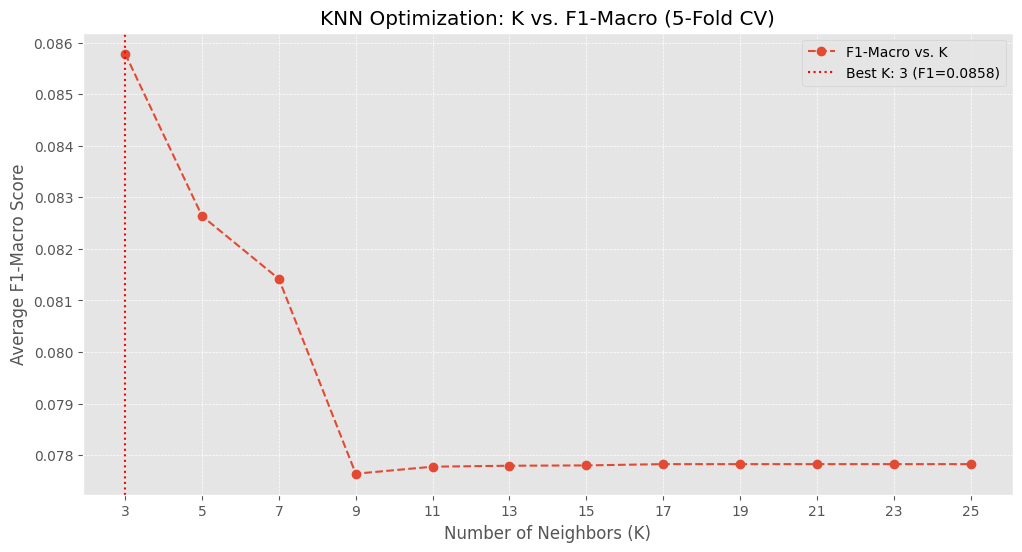


--- [Entrenamiento Final] ---
Entrenando modelo final en TODOS los 2400 datos de train usando K=3...
manual_knn_classifier (Cosine Similarity) initialized. Ready to 'fit' data.
Data fitted. Stored 2400 training samples.
Modelo final guardado en 'knn_model_final.joblib'
Metadatos guardados en 'model_metadata.json'

--- [Evaluación Final en Test Set] ---


Predicting Proba (k=3, metric=cosine):   0%|          | 0/600 [00:00<?, ?it/s]

ManualMetrics initialized.
  Accuracy (Test): 0.6417
  F1-Macro (Test): 0.0765
  Precision (Test): 0.0740
  Recall (Test): 0.0806


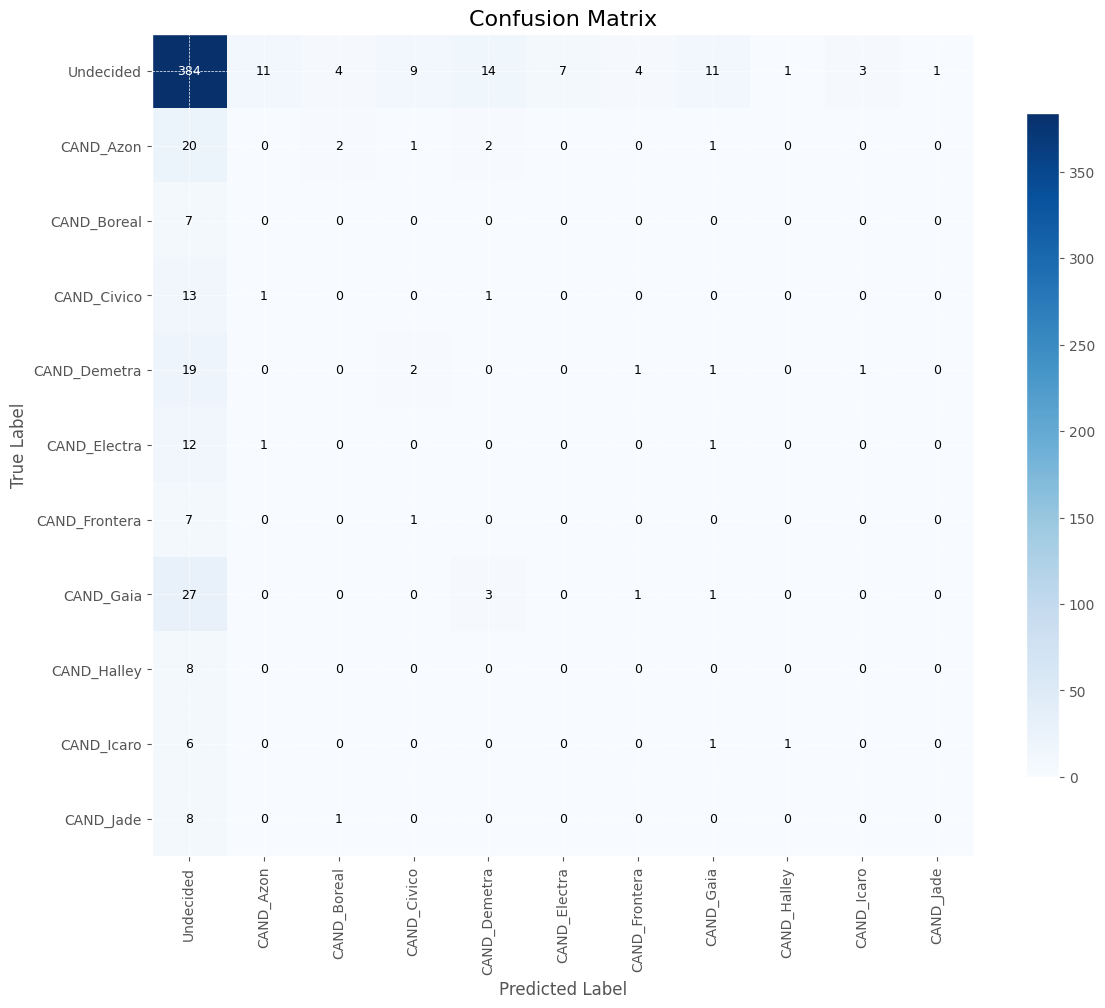


--- [Simulación de Producción (model_exporter)] ---
Datos de entrada (raw): {'age': 31.0, 'household_size': 3.0, 'job_tenure_years': 6.0, 'tv_news_hours': 0.0, 'social_media_hours': 3.0, 'gender': 1.0, 'education': 5.0, 'marital_status': 2.0, 'has_children': 0.0, 'urbanicity': 1.0, 'region': 3.0, 'employment_status': 3.0, 'employment_sector': 0.0, 'income_bracket': 3.0, 'union_member': 0.0, 'public_sector': 0.0, 'small_biz_owner': nan, 'home_owner': 0.0, 'owns_car': 1.0, 'voted_last': 1.0, 'party_id_strength': 2.0, 'trust_media': 9.0, 'wa_groups': 1.0, 'civic_participation': 5.0}
Valor Real: Undecided (ID: 0)
model_exporter initialized. Ready to load artifacts.
--- Artifacts Loaded Successfully (Final Pipeline) ---
  Preprocessor: data_preprocessor.joblib
  Feature Selector: feature_selector.joblib
  LR Probas Model: lr_probas_model.joblib
  Model:        knn_model_final.joblib

  Using Final Configuration:
    - K:           3
    - Metric:      cosine


Predicting Proba (k=3, metric=cosine):   0%|          | 0/1 [00:00<?, ?it/s]

Error during single prediction: shapes (2400,10) and (21,) not aligned: 10 (dim 1) != 21 (dim 0)

--- Resultado de la Predicción ---


KeyError: 'prediction_label'

In [30]:
NUMERICAL_FEATURES = [
    'age', 'household_size', 'job_tenure_years',
    'tv_news_hours', 'social_media_hours'
]

ORDINAL_FEATURES = [
    'gender', 'education', 'marital_status', 'has_children', 'urbanicity',
    'region', 'employment_status', 'employment_sector', 'income_bracket',
    'union_member', 'public_sector', 'small_biz_owner', 'home_owner',
    'owns_car', 'voted_last', 'party_id_strength', 'trust_media',
    'wa_groups', 'civic_participation'
]

ALL_FEATURES = NUMERICAL_FEATURES + ORDINAL_FEATURES

K_RANGE_TO_TEST = range(3, 27, 2)


def main():
    """
    Ejecuta el pipeline de entrenamiento completo.
    """

    # Cargar Datos
    loader = Data_Loader(
        file_path="/content/voter_intentions_3000.csv",
        numerical_features=NUMERICAL_FEATURES,
        ordinal_features=ORDINAL_FEATURES
    )
    X_raw, y_raw, target_map = loader.load_dataset()

    # Dividir Datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y_raw,
        test_size=0.2,
        random_state=42,  # Para reproducibilidad
        stratify=y_raw    # Esencial para desbalance de clases
    )
    print(f"\nDatos divididos. Train: {X_train.shape}, Test: {X_test.shape}")

    # Preprocesar Datos
    preprocessor = Data_Preprocessor(
        numerical_features=NUMERICAL_FEATURES,
        ordinal_features=ORDINAL_FEATURES
    )
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    preprocessor.save_processor("data_preprocessor.joblib")

    # Selección de Features (LDA)
    selector_lda = Feature_Extractor(n_lda_components=10) # 11 clases - 1
    X_train_lda = selector_lda.fit_transform(X_train_processed, y_train)
    X_test_lda = selector_lda.transform(X_test_processed)
    selector_lda.save_transformer("feature_selector.joblib")

    # Entrenar LR-Probas
    print("\n--- [Entrenamiento LR-Probas] ---")
    # Usamos 'balanced' para ayudar con el desbalance de clases
    lr_model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        class_weight='balanced', # ¡Importante!
        max_iter=1000,
        random_state=42
    )

    lr_model.fit(X_train_processed, y_train)

    # Generar probabilidades para los sets
    X_train_probas = lr_model.predict_proba(X_train_processed)
    X_test_probas = lr_model.predict_proba(X_test_processed)
    joblib.dump(lr_model, "lr_probas_model.joblib")
    print("Modelo LR-Probas guardado en 'lr_probas_model.joblib'")
    print(f"Shape de LR-Probas (Train): {X_train_probas.shape}")

    # Concatenar Features, simulando un Embedding local con la nueva info
    X_train_final = np.concatenate([X_train_lda, X_train_probas], axis=1)
    X_test_final = np.concatenate([X_test_lda, X_test_probas], axis=1)
    n_features_final = X_train_final.shape[1]
    final_cols = [f"F_{i+1}" for i in range(n_features_final)]
    X_train_final = pd.DataFrame(X_train_final, columns=final_cols)
    X_test_final = pd.DataFrame(X_test_final, columns=final_cols)
    print(f"\nEmbeddings combinados creados. Shape final: {X_train_final.shape}")

    # Optimizar K
    optimizer = K_Optimizer(
        classifier_class=Manual_KNN_Classifier,
        metrics_class=Metrics,
        cv_class=Manual_Cross_Validator,
        k_range=K_RANGE_TO_TEST,
        n_splits=5
    )
    best_k = optimizer.find_best_k(X_train_lda, y_train)
    optimizer.plot_k_optimization()

    # Entrenar Modelo Final
    print(f"\n--- [Entrenamiento Final] ---")
    print(f"Entrenando modelo final en TODOS los {len(X_train_lda)} datos de train usando K={best_k}...")

    final_model = Manual_KNN_Classifier()
    final_model.fit(X_train_lda, y_train)
    joblib.dump(final_model, "knn_model_final.joblib")
    print("Modelo final guardado en 'knn_model_final.joblib'")

    # Guardar Metadata
    metadata = {
        'best_k': best_k,
        'metric': 'cosine',
        'n_features_in': len(ALL_FEATURES),
        'n_features_out_lda': X_train_lda.shape[1],
        'model_date': pd.Timestamp.now().isoformat()
    }
    with open('model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=4)
    print("Metadatos guardados en 'model_metadata.json'")

    # Evaluación Final
    print(f"\n--- [Evaluación Final en Test Set] ---")

    y_pred_test = final_model.predict(X_test_lda, k=best_k)
    y_true_test = y_test.values
    metrics_calc = Metrics()
    final_accuracy = metrics_calc.accuracy_score(y_true_test, y_pred_test)
    final_prf_scores = metrics_calc.precision_recall_f1(y_true_test, y_pred_test)

    print(f"  Accuracy (Test): {final_accuracy:.4f}")
    print(f"  F1-Macro (Test): {final_prf_scores['f1_macro']:.4f}")
    print(f"  Precision (Test): {final_prf_scores['precision_macro']:.4f}")
    print(f"  Recall (Test): {final_prf_scores['recall_macro']:.4f}")

    cm = metrics_calc.confusion_matrix(y_true_test, y_pred_test)
    class_names = [target_map[i] for i in sorted(target_map.keys())]
    metrics_calc.plot_confusion_matrix(cm, class_names)

    # Exportador
    print(f"\n--- [Simulación de Producción (model_exporter)] ---")

    sample_data_dict = X_test.iloc[0].to_dict()
    true_label_id = y_test.iloc[0]

    print(f"Datos de entrada (raw): {sample_data_dict}")
    print(f"Valor Real: {target_map[true_label_id]} (ID: {true_label_id})")

    # Cargar TODOS los artefactos guardados
    exporter = Model_Exporter()
    exporter.load_artifacts(
        preprocessor_path="data_preprocessor.joblib",
        feature_selector_path="feature_selector.joblib",
        lr_probas_path="lr_probas_model.joblib",
        model_path="knn_model_final.joblib",
        metadata_path="model_metadata.json",
        target_map_path="target_map.json"
    )

    # 9c. Realizar una predicción única
    prediction = exporter.predict_single(sample_data_dict)

    print("\n--- Resultado de la Predicción ---")
    print(f"  Candidato: {prediction['prediction_label']}")
    print(f"  ID: {prediction['prediction_id']}")
    print(f"  Confianza: {prediction['confidence']:.2%}")
    print("-----------------------------------")
    print("PIPELINE DE ENTRENAMIENTO COMPLETADO.")


# Ejecutar el script principal
if __name__ == "__main__":
    main()